__Generating realisations__ 
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2scat/blob/main/notebooks/synthesis.ipynb)

This tutorial is a basic overview of how one may use the scattering covariances as a statistical generative model. 

Generative AI models typically require the abundance of realistic training data. In many (often high dimensional) application domains, such as the sciences, such training data does not exist, limiting generative AI approaches.

One may instead construct an expressive statistical representation from which, provided at least a single fiducial realisation, many realisations may be drawn. This concept is actually very familiar, particularly in cosmology where it is typical to draw Gaussian realisations from a known power spectrum.  However, this generative model does not capture complex non-linear structural information.

Here we will instead use the scattering covariances $\mathcal{S}$ as our statistical representation. Given $\mathcal{S}$ is a non-linear function of the data, generating new realisations isn't quite so straightforward.  In fact, to do so we'll need to solve an optimisation problem:

$$ f = \min_{\hat{f}}\Big [ \mathcal{S}(\hat{f}) - \mathcal{T} \Big]$$

where $\mathcal{T} = \mathcal{S}(f^{\text{in}})$ are the target covariances computed from the signal we are aiming to emulate $f^{\text{in}}$. To solve this optimisation with gradient based methods we clearly need to be able to differentiate through $\mathcal{S}$ which is a complex function involving wavelet transforms and non-linearities. 

As ``S2SCAT`` is a ``JAX`` package, we can readily access these gradients, so lets see exactly how this works! 

## Import the package

Lets first import ``S2SCAT`` and some basic plotting functions. We'll also pick up ``pickle`` to load the targets which have been stored just to save you some time.

In [10]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install a spherical plotting package.
!pip install cartopy &> /dev/null

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2scat &> /dev/null
    !mkdir data/
    # Update below to include data files that we need on colab
    # !wget https://github.com/astro-informatics/s2fft/raw/main/notebooks/data/Gaia_EDR3_flux.npy -P data/ &> /dev/null

In [12]:
import jax, pickle
jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt 
import numpy as np 
import cartopy.crs as ccrs 
import s2scat, s2fft
from s2scat.core import synthesis

## Configure the problem

Lets set up the target field we are aiming to emulate, and the hyperparameters of the scattering covariance representation we will work with.

In [2]:
L = 128                # Spherical harmonic bandlimit.
N = 3                  # Azimuthal bandlimit (directionality).
J_min = 0              # Minimum wavelet scale.
reality = True         # Input signal is real.
recursive = False      # Use the fully precompute transform.

# Lets load in the spherical field we wish to emulate and its harmonic coefficients.
f = np.load('data/WL_example_f_{}.npy'.format(L))
flm = np.load('data/WL_example_flm_{}.npy'.format(L))

# Also lets load in the target scattering covariances, generated from f and flm.
file = 'data/targets_{}.pickle'.format(L)
with open(file, 'rb') as handle:
    targets, norm = pickle.load(handle)

Before calling the scattering transform you need to run configuration, which will generate any precomputed arrays and cache them. When running the recurisve transform this shouldn't take much memory at all. However, the fully precompute transform, which is much faster, can be extremely memory hungry at L ~ 512 and above!

In [3]:
config = s2scat.configure(L, N, J_min, reality, recursive)

## Define a loss function

Lets define a simple $\ell_2$-loss function which just computes the mean squared error between the scattering covariances computed at our current iterant and those of the target. In practice, any loss could be considered here, however we'll use the most straightforward scenario for this demonstration.

In [4]:
def loss_func(glm):
    predicts = s2scat.scatter(glm, L, N, J_min, reality, config, norm, recursive)
    return synthesis.l2_covariance_loss(predicts, targets)

## Generate an initial estimate

We need to choose a set of harmonic coefficients $g_{\ell m}$ from which to start our optimisation. Strictly speaking, we should start from Gaussianly distributed random signal to ensure we form a macro-canonical model of our target field, and we will do precisely this. However, in practice it may be better to start from e.g. a Gaussian random field, generated from a fiducial power spectrum, as this may reduce the total number of iterations required for convergence. 

In any case, lets generate a starting signal.

In [5]:
# Compute the standard deviation of the target field.
sigma_bar = np.std(np.abs(flm)[flm!=0])

# Generate Gaussian random harmonic coefficients with the correct variance.
glm = np.random.randn(L, L) * sigma_bar + 1j*np.random.randn(L, L) * sigma_bar 
#JDM: above should be updated to use s2fft generator

# Save the starting noise signal for posterity and plotting!
glm_start = s2scat.operators.spherical.make_flm_full(glm, L)
g_start = s2fft.inverse(glm_start, L, reality=reality, method="jax")

## Minimise the objective

Now we can pass all these components to ``optax``, which we have internally configured to use the adam optimizer to minimise the loss and return us a synthetic realisation which should approximate the target field statistics.

In [7]:
# Run the optimisation to generate a new realisation glm.
glm, _ = synthesis.fit_optax(glm, loss_func, niter=400, learning_rate=1e-3)

# Convert the synthetic harmonic coefficients into a pixel-space image.
glm_end = s2scat.operators.spherical.make_flm_full(glm, L)
g_end = s2fft.inverse(glm_end, L, reality=reality, method="jax")

Iter 0, Loss: 4835.4566906126, Time = 10.18631 s/iter
Iter 10, Loss: 1651.0167787240, Time = 0.40225 s/iter
Iter 20, Loss: 594.4745953766, Time = 0.40625 s/iter
Iter 30, Loss: 257.6965065194, Time = 0.40184 s/iter
Iter 40, Loss: 136.3605673887, Time = 0.40089 s/iter
Iter 50, Loss: 84.3637307917, Time = 0.41000 s/iter
Iter 60, Loss: 58.0842847153, Time = 0.40909 s/iter
Iter 70, Loss: 42.8534719842, Time = 0.39461 s/iter
Iter 80, Loss: 33.0514028891, Time = 0.40044 s/iter
Iter 90, Loss: 26.2475698638, Time = 0.39786 s/iter
Iter 100, Loss: 21.2788567132, Time = 0.40001 s/iter
Iter 110, Loss: 17.5206491175, Time = 0.42023 s/iter
Iter 120, Loss: 14.6040898149, Time = 0.40343 s/iter
Iter 130, Loss: 12.2973992476, Time = 0.40263 s/iter
Iter 140, Loss: 10.4459615742, Time = 0.42627 s/iter
Iter 150, Loss: 8.9416709122, Time = 0.40609 s/iter
Iter 160, Loss: 7.7062505656, Time = 0.39801 s/iter
Iter 170, Loss: 6.6822974969, Time = 0.41140 s/iter
Iter 180, Loss: 5.8268318607, Time = 0.40202 s/iter


## Check the synthesis

Finally, lets check how our starting and ending realisations shape up against the target field!

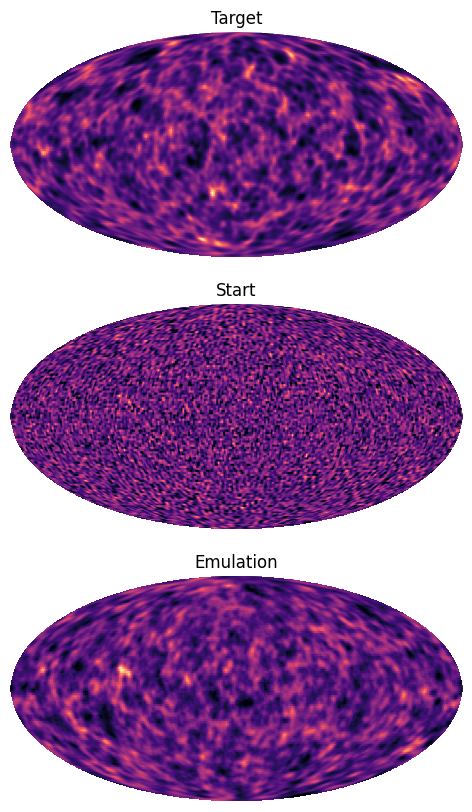

In [20]:
fields = [f, g_start, g_end]
titles = ["Target", "Start", "Emulation"]
fig, axs = plt.subplots(3, 1, subplot_kw={'projection': ccrs.Mollweide()}, figsize=(30,10))
mx, mn = np.nanmax(f), np.nanmin(f)
for i in range(3):   
    axs[i].imshow(fields[i], transform=ccrs.PlateCarree(), cmap='magma', vmax=mx, vmin=mn)
    axs[i].set_title(titles[i])
    axs[i].axis('off')
plt.show()